# Text Cleaning and Formatting

This notebook will serve to clean the tweet text and format into a tf-idf structure.

Note: basic cleaning of tweets to remove urls, hashtags, mentions, and non-English characters was already performed during the collection process.

### General Notebook Setup

In [1]:
# Import packages
import pandas as pd 
import re
import nltk
import matplotlib.pyplot as plt
from matplotlib import RcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Set theme for creating visualizations

# Set text sizes
title_size = 22
label_size = 16
tick_text_size = 12

# Set background and text colors
background_color = '#F7F7F4'
text_color = 'black'

# Set options of colors for use in plotting
color1 = "#9FB881"  # (dark green)
color2 = "#B89A81"  # (brown)
color3 = "#2E4057"  # (charcoal)
color4 = "#cfbaa9"  # (light brown)
color5 = "#806248"  # (dark brown)
color6 = "#B8B681"  # (dark tan)
color7 = "#D19C1D"  # (gold)

# Set theme for creating visualizations
plt.rcParams.update({
                     'axes.edgecolor': 'white',
                     'axes.facecolor': background_color,
                     'axes.grid': True,
                     'axes.labelcolor': text_color,
                     'axes.titlesize': title_size,
                     'axes.labelsize': label_size,
                     'figure.facecolor': background_color,
                     'text.color': text_color,
                     'xtick.color': text_color,
                     'xtick.labelsize' : tick_text_size,
                     'ytick.color': text_color,
                     'ytick.labelsize' : tick_text_size,
                     })

### Read In Tweet Data

In [3]:
# Read in data
data = pd.read_csv('./Data/all_data.csv')

# View first few rows of data
data.head(3)

,Unnamed: 0,created_at,text,hashtags,user_mention_ids,user_mention_screen_names,retweet_count,favorite_count,in_reply_to_user_id,in_reply_to_screen_name,...,user_id,user_screen_name,user_name,user_location,user_friends_count,user_followers_count,user_favourites_count,user_verfied,user_statuses_count,topic_y
0,0,2022-10-18 00:00:00,Sharp words on guns in Shane Hazel to Stacey A...,['gagovdebate'],[],[],5,24,NaN,NaN,...,25282846,SimonesNews,Simone Sebastian,Washington DC,3110,5830,1445,True,4400,abrams
1,1,2022-10-18 00:00:01,Stacey Abrams won tonight. She kept to the fac...,[],[],[],0,6,NaN,NaN,...,1312393604439183361,nching0,Thee Lost Edges of Candace 🪥,"34.2073° N, 84.1402° W",922,752,101529,False,61963,abrams
2,2,2022-10-18 00:00:01,"Why did Joe Rogan send his little brother, Sha...",['GAGovDebate'],[],[],0,5,NaN,NaN,...,897218253826555905,JTaylorSkinner,Jenn Taylor-Skinner (she/her),Seattle,17762,25727,82402,False,43808,abrams


### Perform Basic Text Cleaning

In [4]:
# Create regex statement for cleaning 
replace = [
    (r"[\t\n\r\*\.\@\,\-\/\:\"\!\?\)\#\(\'\;\&\^\$\[\]\=\%\|]", " "), # Punctuation and other junk
    (r"\d+", " "),                                                    # Remove digits
    (r"@[A-Za-z0-9]+"," "),                                           # Remove mentions
    (r"abrams|kemp|Abrams|Kemp"," "),                                 # Remove mention of abrams or kemp
    (r"\s+", " ")                                                     # Stip extra whitespace
]

# Loop through all tweets and apply regex cleaning 
train_sentences = []
for i, d in enumerate(data['text']):
    for repl in replace:
        d = re.sub(repl[0], repl[1], d)
    train_sentences.append(d)

# Add cleaned text to as column in dataframe
data['cleaned_text'] = train_sentences

# View first few rows of text and cleaned text columns
data[['text', 'cleaned_text']].head(3)

,text,cleaned_text
0,Sharp words on guns in Shane Hazel to Stacey A...,Sharp words on guns in Shane Hazel to Stacey Y...
1,Stacey Abrams won tonight. She kept to the fac...,Stacey won tonight She kept to the facts answe...
2,"Why did Joe Rogan send his little brother, Sha...",Why did Joe Rogan send his little brother Shan...


In [5]:
# Get nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Define search words used in collecting tweets 
search_words = ['georgia', 'governor', 'gov', 'election', 'ga',
                'brian', 'kemp', 'kemps', 'brainkemp', 'kemp',
                'stacey', 'abrams', 'staceyabrams', 'abramss',
                'nominee', 'candidate', 'incumbent']

# Define method to lowercase and remove stopwords and search words from tweet
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = [word for word in tweet.split() if word not in stopwords]
    tweet = [word for word in tweet if word not in search_words]
    tweet = ' '.join(tweet)
    return tweet

# Apply method to cleaned_text column
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: clean_tweet(x))

# View first few rows of text and cleaned text columns
data[['text', 'cleaned_text']].head(10)

,text,cleaned_text
0,Sharp words on guns in Shane Hazel to Stacey A...,sharp words guns shane hazel keep going back g...
1,Stacey Abrams won tonight. She kept to the fac...,tonight kept facts answered questions math poi...
2,"Why did Joe Rogan send his little brother, Sha...",joe rogan send little brother shane interrupt ...
3,Viral handbag designer and EBONY Power100 Styl...,viral handbag designer ebony power style curat...
4,THE MOST DANGEROUS THING FACING GEORGIA IS 4 M...,dangerous thing facing years wow
5,Mrs. Abrams showed the same poise and skill as...,mrs showed poise skill kbj earlier year face g...
6,Thanks for the link BDD! Who was the other guy...,thanks link bdd guy seems lot like republicans...
7,"Stacey Abrams: ""The most dangerous thing facin...",dangerous thing facing four years
8,"Stacey Abrams is on ,",
9,Yeah . But they dont have to . If he told them...,yeah dont told vote still would hes got black ...


In [6]:
# Remove any tweets that have no words after cleaning
data = data[data['cleaned_text'] != '']

# View first few rows of text and cleaned text columns
data[['text', 'cleaned_text']].head(10)

,text,cleaned_text
0,Sharp words on guns in Shane Hazel to Stacey A...,sharp words guns shane hazel keep going back g...
1,Stacey Abrams won tonight. She kept to the fac...,tonight kept facts answered questions math poi...
2,"Why did Joe Rogan send his little brother, Sha...",joe rogan send little brother shane interrupt ...
3,Viral handbag designer and EBONY Power100 Styl...,viral handbag designer ebony power style curat...
4,THE MOST DANGEROUS THING FACING GEORGIA IS 4 M...,dangerous thing facing years wow
5,Mrs. Abrams showed the same poise and skill as...,mrs showed poise skill kbj earlier year face g...
6,Thanks for the link BDD! Who was the other guy...,thanks link bdd guy seems lot like republicans...
7,"Stacey Abrams: ""The most dangerous thing facin...",dangerous thing facing four years
9,Yeah . But they dont have to . If he told them...,yeah dont told vote still would hes got black ...
10,"Well Done Stacey Abrams!Facts, Truth, and Inte...",well done facts truth integrity debated every ...


### Split tweets into those about Abrams and those about Kemp

In [7]:
data_abrams = data[data['topic_y'].str.contains('abrams')]
data_kemp = data[data['topic_y'].str.contains('kemp')]

### Convert Cleaned Text to Vector Form

In [8]:
### Get number of words (vocab size) for each dataset 

# All Tweets
vocab_size_all = len(set([word for tweet in data['cleaned_text'] for word in tweet.split(' ')]))
print('Number of Words - All Tweets:  ', vocab_size_all)

# Abrams Tweets
vocab_size_abrams = len(set([word for tweet in data_abrams['cleaned_text'] for word in tweet.split(' ')]))
print('Number of Words - Abrams Tweets:', vocab_size_abrams)

# Kemp Tweets
vocab_size_kemp = len(set([word for tweet in data_kemp['cleaned_text'] for word in tweet.split(' ')]))
print('Number of Words - Kemp Tweets:  ', vocab_size_kemp)

Number of Words - All Tweets:   24237
Number of Words - Abrams Tweets: 19630
Number of Words - Kemp Tweets:   13137


In [9]:
### Transform text to vector form - term frequency matrix

# All Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_all = CountVectorizer(max_features=vocab_size_all, max_df=0.95, min_df=0.005, stop_words='english')
tf_all = tf_vectorizer_all.fit_transform(data['cleaned_text'])
tf_feature_names_all = tf_vectorizer_all.get_feature_names()

# Abrams Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_abrams = CountVectorizer(max_features=vocab_size_abrams, max_df=0.95, min_df=0.005, stop_words='english')
tf_abrams = tf_vectorizer_abrams.fit_transform(data_abrams['cleaned_text'])
tf_feature_names_abrams = tf_vectorizer_abrams.get_feature_names()

# Kemp Tweets - fit vectorizer to data and get feature names (words for each column)
tf_vectorizer_kemp = CountVectorizer(max_features=vocab_size_kemp, max_df=0.95, min_df=0.005, stop_words='english')
tf_kemp = tf_vectorizer_kemp.fit_transform(data_kemp['cleaned_text'])
tf_feature_names_kemp = tf_vectorizer_kemp.get_feature_names()

/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
### Get text into tf-idf form

# All Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_all = TfidfVectorizer(max_features=vocab_size_all, max_df=0.95, stop_words='english')
tfidf_all = tfidf_vectorizer_all.fit_transform(data['cleaned_text'])
tfidf_feature_names_all = tfidf_vectorizer_all.get_feature_names()

# Abrams Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_abrams = TfidfVectorizer(max_features=vocab_size_abrams, max_df=0.95, stop_words='english')
tfidf_abrams = tfidf_vectorizer_abrams.fit_transform(data_abrams['cleaned_text'])
tfidf_feature_names_abrams = tfidf_vectorizer_abrams.get_feature_names()

# Kemp Tweets - fit tfidf vectorizer to data and get feature names (words for each column)
tfidf_vectorizer_kemp = TfidfVectorizer(max_features=vocab_size_kemp, max_df=0.95, stop_words='english')
tfidf_kemp = tfidf_vectorizer_kemp.fit_transform(data_kemp['cleaned_text'])
tfidf_feature_names_kemp = tfidf_vectorizer_kemp.get_feature_names()

In [11]:
# Confirm feature names (words) from tf and tfidf are the same
print('All Tweets:   ', [n for n in tf_feature_names_all if n not in tfidf_feature_names_all])
print('Abrams Tweets:', [n for n in tf_feature_names_abrams if n not in tfidf_feature_names_abrams])
print('Kemp Tweets:  ', [n for n in tf_feature_names_kemp if n not in tfidf_feature_names_kemp])

All Tweets:    []
Abrams Tweets: []
Kemp Tweets:   []


### Topic Modeling

In [12]:
# Set number of topics to model
num_topics = 6

In [13]:
# Define method to visualize words for each topic
# Note/Reference: this code is adapted from code provided by the ANLY 580 professors in Lab assignment #4
def plot_top_words(model, feature_names, n_top_words, title, save_as):
    plt.clf()
    cols = 3
    rows = num_topics // cols + num_topics % cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[::-1][:n_top_words]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color1)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': label_size}
                     )
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=tick_text_size)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=title_size)
    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.2)
    plt.savefig('Visualizations/'+save_as)
    plt.show()

##### **NMF**

In [14]:
# Instantiate the model
mod_nmf_abrams = NMF(n_components=num_topics)
mod_nmf_kemp = NMF(n_components=num_topics)

# Fit-Transform the model to the data
feat_nmf_abrams = mod_nmf_abrams.fit_transform(tfidf_abrams)
feat_nmf_kemp = mod_nmf_kemp.fit_transform(tfidf_kemp)

# See shape of features
print('NMF Features Shape - Abrams:', feat_nmf_abrams.shape)
print('NMF Features Shape - Kemp:', feat_nmf_kemp.shape)

/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF Features Shape - Abrams: (35110, 6)
NMF Features Shape - Kemp: (14657, 6)


/opt/homebrew/Caskroom/miniforge/base/envs/anly_nn/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


<Figure size 640x480 with 0 Axes>

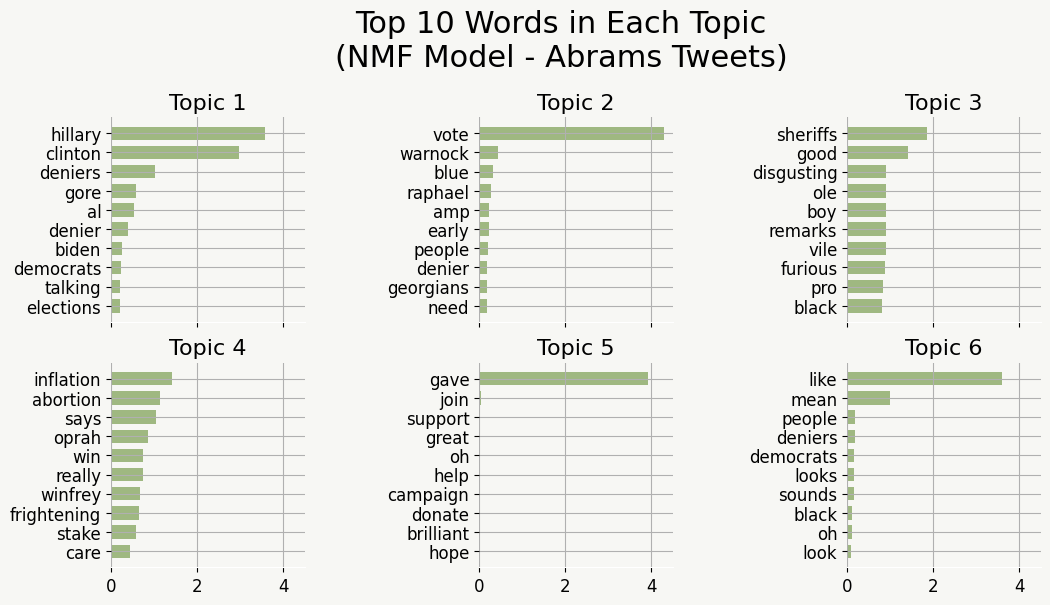

In [15]:
# Plot top 10 words of each topic - NMF Model - Abrams tweets
plot_top_words(model=mod_nmf_abrams, 
               feature_names=tfidf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Abrams Tweets)', 
               save_as='topic_mod_nmf_abrams')

<Figure size 640x480 with 0 Axes>

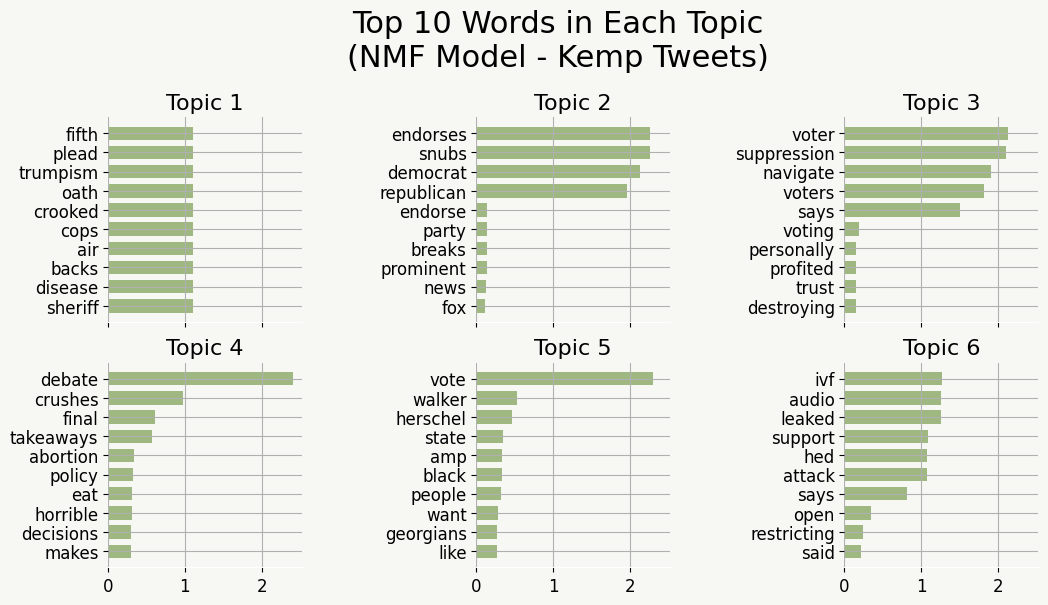

In [16]:
# Plot top 10 words of each topic - NMF Model - Kemp tweets
plot_top_words(model=mod_nmf_kemp, 
               feature_names=tfidf_feature_names_kemp, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(NMF Model - Kemp Tweets)',
               save_as='topic_mod_nmf_kemp')

##### **LDA**

In [17]:
# Instantiate the model
mod_lda_abrams = LatentDirichletAllocation(n_components=num_topics)
mod_lda_kemp = LatentDirichletAllocation(n_components=num_topics)

# Fit-Transform the model to the data
feat_lda_abrams = mod_lda_abrams.fit_transform(tf_abrams)
feat_lda_kemp = mod_lda_kemp.fit_transform(tf_kemp)

# See shape of features
print('LDA Features Shape - Abrams:', feat_lda_abrams.shape)
print('LDA Features Shape - Kemp:', feat_lda_kemp.shape)

LDA Features Shape - Abrams: (35110, 6)
LDA Features Shape - Kemp: (14657, 6)


<Figure size 640x480 with 0 Axes>

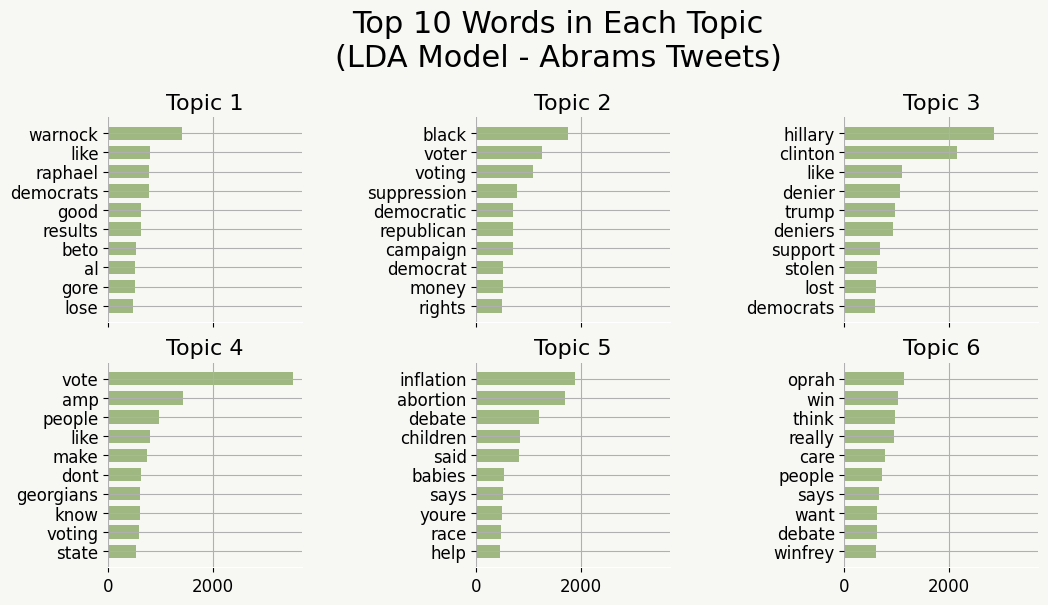

In [18]:
# Plot top 10 words of each topic - LDA Model - Abrams tweets
plot_top_words(model=mod_lda_abrams, 
               feature_names=tf_feature_names_abrams, 
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Abrams Tweets)',
               save_as='topic_mod_lda_abrams')

<Figure size 640x480 with 0 Axes>

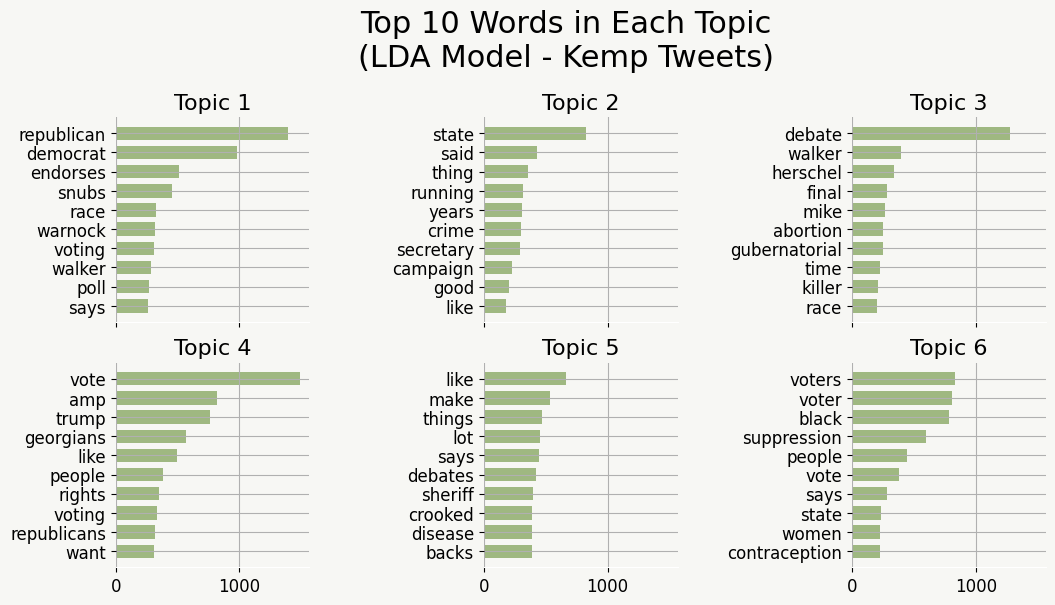

In [19]:
# Plot top 10 words of each topic - LDA Model - Kemp tweets
plot_top_words(model=mod_lda_kemp, 
               feature_names=tf_feature_names_kemp,
               n_top_words=10, 
               title='Top 10 Words in Each Topic\n(LDA Model - Kemp Tweets)',
               save_as='topic_mod_lda_kemp')